In [83]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
%matplotlib inline

# Dataset

In [84]:
df = pd.read_csv('../data/heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# EDA and Data cleaning

In [85]:
df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [86]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [87]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [88]:
for column in df.columns:
    print(column)
    print(df[column].unique()[0:5])
    print(df[column].nunique())
    print()

age
[63 37 41 56 57]
41

sex
[1 0]
2

cp
[3 2 1 0]
4

trtbps
[145 130 120 140 172]
49

chol
[233 250 204 236 354]
152

fbs
[1 0]
2

restecg
[0 1 2]
3

thalachh
[150 187 172 178 163]
91

exng
[0 1]
2

oldpeak
[2.3 3.5 1.4 0.8 0.6]
40

slp
[0 2 1]
3

caa
[0 2 1 3 4]
5

thall
[1 2 3 0]
4

output
[1 0]
2



# Columns with nulls/NA thall = 0 and caa = 4

In [89]:
df.thall.value_counts()

thall
2    166
3    117
1     18
0      2
Name: count, dtype: int64

In [90]:
df.caa.value_counts()

caa
0    175
1     65
2     38
3     20
4      5
Name: count, dtype: int64

In [91]:
df = df[(df.thall != 0) & (df.caa != 4)]

# Checking target balance

In [92]:
df.output.value_counts()

output
1    160
0    136
Name: count, dtype: int64

# Columns correlation

In [93]:
df.corr().abs().style.background_gradient(cmap='viridis')

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,0.089820,0.061405,0.288701,0.200920,0.133022,0.112365,0.395989,0.098051,0.199373,0.161758,0.364229,0.063373,0.225453
sex,0.089820,1.000000,0.048023,0.059520,0.193749,0.036981,0.072303,0.058293,0.140791,0.102641,0.028719,0.088788,0.212017,0.285322
cp,0.061405,0.048023,1.000000,0.044610,0.067926,0.118337,0.039106,0.296621,0.383902,0.142159,0.104675,0.226203,0.162660,0.423425
trtbps,0.288701,0.059520,0.044610,1.000000,0.126705,0.183658,0.117539,0.051817,0.070501,0.196793,0.126742,0.102042,0.063773,0.148922
chol,0.200920,0.193749,0.067926,0.126705,1.000000,0.014286,0.142039,0.001947,0.062132,0.042144,0.005572,0.119006,0.082496,0.076541
fbs,0.133022,0.036981,0.118337,0.183658,0.014286,1.000000,0.082361,0.007155,0.001863,0.007062,0.046550,0.151259,0.017891,0.004680
restecg,0.112365,0.072303,0.039106,0.117539,0.142039,0.082361,1.000000,0.030001,0.065623,0.055528,0.090915,0.111317,0.008723,0.131716
thalachh,0.395989,0.058293,0.296621,0.051817,0.001947,0.007155,0.030001,1.000000,0.383671,0.346742,0.388453,0.267861,0.111961,0.426655
exng,0.098051,0.140791,0.383902,0.070501,0.062132,0.001863,0.065623,0.383671,1.000000,0.287812,0.248879,0.146783,0.224178,0.425085
oldpeak,0.199373,0.102641,0.142159,0.196793,0.042144,0.007062,0.055528,0.346742,0.287812,1.000000,0.577779,0.292905,0.211675,0.428804


# Split the data

In [94]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=len(df_test), random_state=1)

len(df_train), len(df_val), len(df_test)

(176, 60, 60)

In [95]:
df_train_full = df_train_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_full = df_train_full['output'].values
y_train = df_train['output'].values
y_val = df_val['output'].values
y_test = df_test['output'].values

del df_train_full['output']
del df_train['output']
del df_val['output']
del df_test['output']

X_train_full = df_train_full.values
X_train = df_train.values
X_val = df_val.values
X_test = df_test.values

# ROC AUC Feature Importance

In [96]:
scores = []

for column in list(df_train.columns):
    auc = roc_auc_score(y_train, df_train[column])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[column])
    
    scores.append((column, auc))
    
df_scores = pd.DataFrame(scores, columns=('feature', 'auc'))
df_scores.sort_values(by='auc', ascending=False)

,feature,auc
2,cp,0.756544
7,thalachh,0.750868
11,caa,0.743790
8,exng,0.710470
9,oldpeak,0.709802
1,sex,0.666667
12,thall,0.666466
10,slp,0.665865
0,age,0.613515
6,restecg,0.560363


# Logistic Regression - Model Tunning Parameter 'C'

In [97]:
scores = []
C = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]

for c in C:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for i, (train_idx, val_idx) in enumerate(kfold.split(X_train_full)):
        X_train_kfold, X_val_kfold = X_train_full[train_idx], X_train_full[val_idx]
        y_train_kfold, y_val_kfold = y_train_full[train_idx], y_train_full[val_idx]

        logistic_kfold_model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=1)
        logistic_kfold_model.fit(X_train_kfold, y_train_kfold)

        y_pred = logistic_kfold_model.predict_proba(X_val_kfold)[:, 1]
        auc = roc_auc_score(y_val_kfold, y_pred)

        scores.append((i, c, auc))

df_scores = pd.DataFrame(scores, columns=('kfold', 'C', 'auc'))
auc_mean = df_scores.groupby('C')['auc'].mean().round(3).values
auc_std = df_scores.groupby('C')['auc'].std().round(3).values

data = {
    'C': C,
    'auc_mean': auc_mean,
    'auc_std': auc_std
}
df_summary = pd.DataFrame(data=data)
df_summary.sort_values(by='auc_mean', ascending=False).head()

,C,auc_mean,auc_std
3,0.5,0.919,0.021
4,1.0,0.918,0.021
5,5.0,0.918,0.015
6,10.0,0.917,0.015
2,0.1,0.914,0.030


# Logistic Regression - Model Tunned 'C' = 0.5

In [98]:
models = []

logistic_model = LogisticRegression(solver='liblinear', C=0.5, max_iter=1000, random_state=1)
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

models.append(('Logistic Regression', round(auc, 3)))

# Decision Tree - Model Tunning Parameter 'max_depth'

In [99]:
scores = []
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths:

    dt = DecisionTreeClassifier(max_depth=depth, random_state=1)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((depth, auc))

df_scores = pd.DataFrame(scores, columns=('max_depth', 'auc'))
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,auc
2,3.0,0.815907
4,5.0,0.810345
5,6.0,0.808676
6,10.0,0.805895
7,15.0,0.799778


# Decision Tree - Model Tunning Parameter 'min_samples_leaf'

In [100]:
scores = []

for depth in [3, 5, 6, 10]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, random_state=1)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

df_scores = pd.DataFrame(scores, columns=('max_depth', 'min_samples_leaf', 'auc'))

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

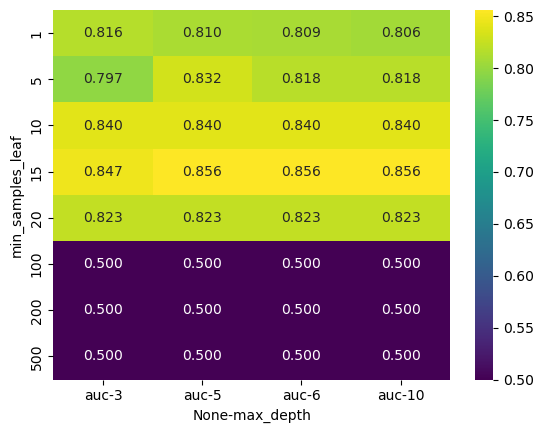

In [101]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])

sns.heatmap(df_scores_pivot, annot=True, fmt=".3f", cmap='viridis')

# Decision Tree - Model Tunned 'max_depth' = 5 and 'min_samples_leaf' = 15

In [102]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, random_state=1)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

models.append(('Decision Tree', round(auc, 3)))

# Random Forest - Model Tunning Parameter 'max_depth' and 'n_estimators'

In [ ]:
scores = []

for d in depths:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))
    
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])
df_scores.sort_values(by='auc', ascending=False).head()

# Random Forest - Model Tunned 'max_depth' = 6 and 'n_estimators' = 10

In [ ]:
rf = RandomForestClassifier(n_estimators=10,
                                    max_depth=6,
                                    random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

models.append(('Random Forest', round(auc, 3)))

# XGBoost - Model Tunning Parameter 'eta'

In [ ]:
features = list(df_train.columns)

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
    
    columns = ['n_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

In [ ]:
scores = []
etas = [0.01, 0.05, 0.1, 0.3, 1]

for eta in etas:

    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=200)

    y_pred = xgb_model.predict(dval)
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((eta, auc))
    
df_scores = pd.DataFrame(scores, columns=['eta', 'auc'])
df_scores.sort_values(by='auc', ascending=False).head()

# XGBoost - Model Tunning Parameter 'max_depth'

In [ ]:
scores = []

for depth in depths:

    xgb_params = {
        'eta': 0.3, 
        'max_depth': depth,
        'min_child_weight': 1,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=200)

    y_pred = xgb_model.predict(dval)
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((depth, auc))
    
df_scores = pd.DataFrame(scores, columns=['max_depth', 'auc'])
df_scores.sort_values(by='auc', ascending=False).head()

# XGBoost - Model Tunning Parameter 'min_child_weight'

In [ ]:
scores = []
weights = [1, 5, 10, 20, 30, 50]

for weight in weights:

    xgb_params = {
        'eta': 0.3, 
        'max_depth': 1,
        'min_child_weight': weight,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=200)

    y_pred = xgb_model.predict(dval)
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((weight, auc))
    
df_scores = pd.DataFrame(scores, columns=['min_child_weight', 'auc'])
df_scores.sort_values(by='auc', ascending=False).head()

# XGBoost - Model Tunning Parameter 'num_boost_round'

In [ ]:
%%capture output

xgb_params = {
        'eta': 0.3, 
        'max_depth': 1,
        'min_child_weight': 5,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
df_scores = parse_xgb_output(output)

In [ ]:
df_scores.sort_values(by='val_auc', ascending=False).head()

# XGBoost - Model Tunned 'eta' = 0.3, 'max_depth' = 1, 'min_child_weight' = 5 and num_boost_round = 120

In [ ]:
xgb_params = {
        'eta': 0.3, 
        'max_depth': 1,
        'min_child_weight': 5,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=120)
y_pred = xgb_model.predict(dval)
auc = roc_auc_score(y_val, y_pred)

models.append(('XGBoost', round(auc, 3)))

# Evaluating the best model

In [ ]:
df_models = pd.DataFrame(models, columns=['Model', 'auc'])
df_models.sort_values(by='auc', ascending=False)

# Final training with chosen model

In [ ]:
rf = RandomForestClassifier(n_estimators=10,
                            max_depth=6,
                            random_state=1)
rf.fit(X_train_full, y_train_full)

y_pred = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)

print(round(auc, 3))

# Selecting the best threshold

In [ ]:
scores = []
thresholds = np.arange(0.0, 1.1, 0.1)

for threshold in thresholds:
    heart_attack = y_pred >= threshold
   
    f1 = f1_score(y_test, heart_attack)
    
    scores.append((threshold, f1))
    
df_scores = pd.DataFrame(scores, columns=['threshold', 'f1'])
df_scores.sort_values(by='f1', ascending=False).head()